<a href="https://colab.research.google.com/github/cerasole/EnvironmentalRadioactivity/blob/main/Notebooks/SpectralFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dello spettro ambientale di un rivelatore a scintillazione a NaI(Tl)

In questo notebook viene mostrata un'analisi standard di calibrazione, studio dei picchi della radioattività ambientale e risoluzione energetica di un rivelatore a ioduro di sodio drogato con Tallio.

In [ ]:
#

## Step 0 - Download dei file ed import dei moduli necessari

In [1]:
!pip install iminuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 8.0 MB/s eta 0:00:00


In [2]:
import os, glob
import glob
import numpy as np

# Visualizzazione
import matplotlib.pyplot as plt
plt.rc("font", size = 16)

# Funzioni per i fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [3]:
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/2.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/3.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/4.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/5.txt

--2025-03-04 20:01:23--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66469 (65K) [text/plain]
Saving to: ‘1.txt’

1.txt               100%[===================>]  64.91K  --.-KB/s    in 0.008s  

2025-03-04 20:01:23 (8.32 MB/s) - ‘1.txt’ saved [66469/66469]



## Step 1 - Lettura e prima esplorazione dello spettro

Il file contiene l'istogramma dei conteggi in ADC acquisiti in 5 minuti.

In [4]:
file = "1.txt"

adc, counts = np.loadtxt(file, unpack = True, skiprows = 14)
adc, counts

(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 8.189e+03, 8.190e+03,
        8.191e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

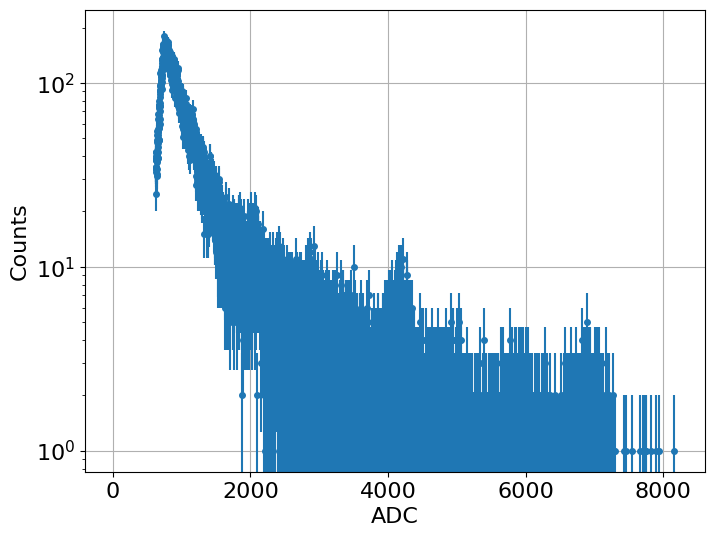

In [5]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    adc,
    counts,
    xerr = (adc[1] - adc[0])/2,
    yerr = np.sqrt(counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.grid()

In [6]:
### Conteggio totale!

np.sum(counts)

79324.0

## Step 2 - Rebin dell'istogramma

L'istogramma mostrato nella figura precedente risulta essere molto confusionario, in quanto ci sono troppi bin. Effettuiamo un opportuno rebin.

Si noti che la dimensione ottimale del rebinnaggio può dipendere dall'intervallo di energie con cui si sta lavorando. Se siamo interessati alle basse energie, ove la statistica è più ricca, potrebbe bastarci anche un rebin di un fattore 8.
Invece, se ci interessano le alte energie conviene effettuare un rebinnaggio con un fattore di rebin più ampio

In [19]:
# Questa è la funzione che mi è stata suggerita dall'AI di Colab
def rebin_histogram (bins, values, rebin):
  new_bins = bins[::rebin]
  new_values = np.sum(values.reshape(-1, rebin), axis = 1)
  return new_bins, new_values

# Questa è la funzione che scriverei io!
def rebin_histogram(bins, values, rebin):
  N = len(bins)
  new_N = int(N // rebin)
  new_bins, new_values = np.zeros(new_N), np.zeros(new_N)
  for i in range(new_N):
    new_bins[i] = np.mean(bins[i*rebin:(i+1)*rebin])
    new_values[i] = np.sum(values[i*rebin:(i+1)*rebin])
  return new_bins, new_values

rebinned_adc, rebinned_counts = rebin_histogram(adc, counts, 26)

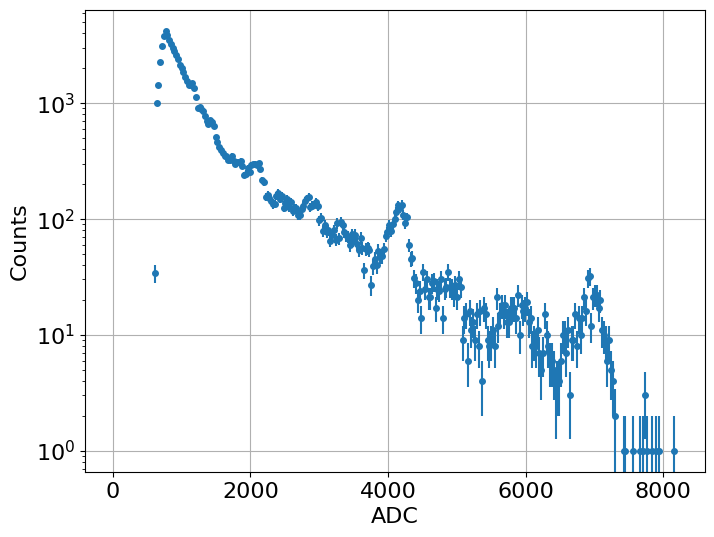

In [20]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_adc,
    rebinned_counts,
    xerr = (rebinned_adc[1] - rebinned_adc[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.grid()

## Step 3 - Calibrazione lineare

Adesso dobbiamo individuare alcuni picchi e procedere ad una calibrazione per convertire gli ADC in energia!



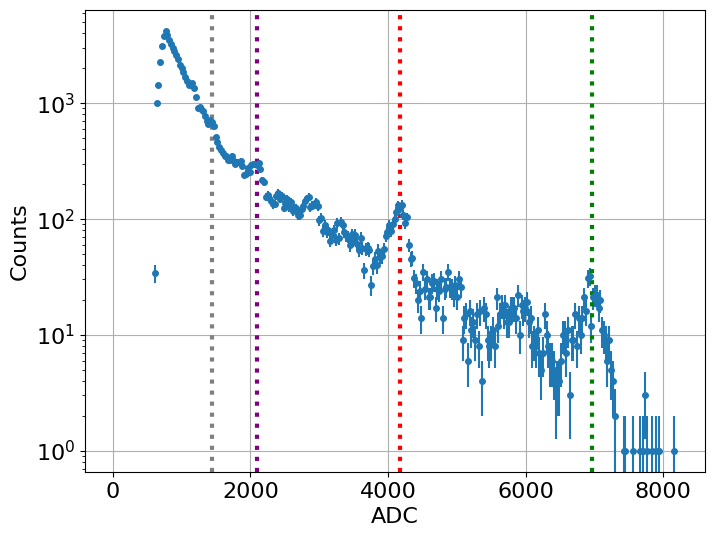

In [21]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_adc,
    rebinned_counts,
    xerr = (rebinned_adc[1] - rebinned_adc[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(1000, 3300)
#ax.set_ylim(50, 2000)
ax.axvline(1440, ls = "dotted", color = "gray", lw = 3) # Picco del Pb-214 a 352 keV
ax.axvline(2090, ls = "dotted", color = "purple", lw = 3) # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
#ax.set_xlim(3500, 8000)
#ax.set_ylim(1, 220)
ax.axvline(4170, ls = "dotted", color = "red", lw = 3) # Picco del Co-60 a 1460 keV
ax.axvline(6960, ls = "dotted", color = "green", lw = 3) # Picco del Tl-208 o 2614 keV
ax.grid()

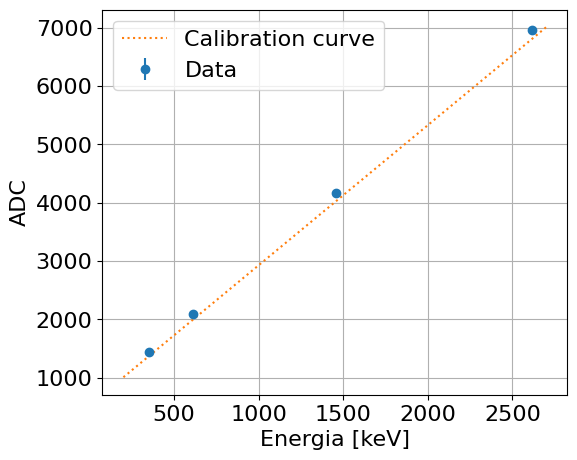

In [22]:
# Calibrazione = conversione da ADC ad energia
adc_peaks = np.array([1440, 2090, 4170, 6960])
adc_peaks_err = np.array([10, 20, 30, 40])
keV_peaks = np.array([352, 609, 1460, 2614])

fig, ax = plt.subplots(figsize = (6, 5))

x = np.linspace(200, 2700)
p0, p1 = 528, 2.4
y = p0 + p1*x

ax.errorbar(
    keV_peaks,
    adc_peaks,
    yerr = adc_peaks_err,
    ls = "None",
    marker = "o",
    label = "Data"
)
ax.plot(x, y, ls = "dotted", label = "Calibration curve")
ax.legend()
plt.xlabel("Energia [keV]")
plt.ylabel("ADC")
plt.grid();

In [23]:
def linear_function (x, p0, p1):
  return p0 + p1*x

loss = LeastSquares(x=keV_peaks, y=adc_peaks, yerror=adc_peaks_err, model = linear_function)
m = Minuit(loss, p0=528, p1=2.4)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.358 (χ²/ndof = 0.7)      │              Nfcn = 41               │
│ EDM = 1.3e-18 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │    583    │    12     │            │            │         │         │       │
│ 1 │ p1   │   2.447   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │        156 -146.90e-3 │
│ p1 │ -146.90e-3   0.000252 │
└────┴───────────────────────┘

In [24]:
p0, p1 = m.params[0].value, m.params[1].value
p0, p1

(583.0985018297508, 2.447110471513173)

In [26]:
rebinned_energy = (rebinned_adc - p0) / p1

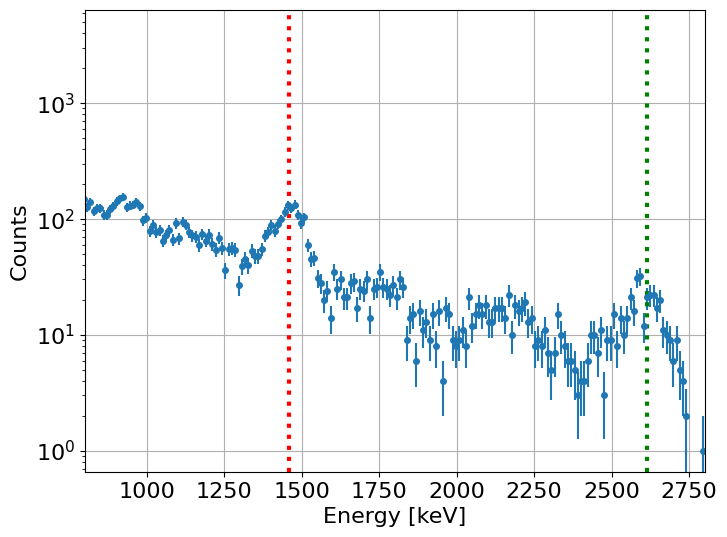

In [27]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_energy,
    rebinned_counts,
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(100, 900)
#ax.set_ylim(100, 2000)
ax.axvline(352, ls = "dotted", color = "gray", lw = 3) # Picco del Pb-214 a 352 keV
ax.axvline(609, ls = "dotted", color = "purple", lw = 3) # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
ax.set_xlim(800, 2800)
#ax.set_ylim(1, 120)
ax.axvline(1460, ls = "dotted", color = "red", lw = 3) # Picco del Co-60 a 1460 keV
ax.axvline(2614, ls = "dotted", color = "green", lw = 3) # Picco del Tl-208 o 2614 keV
ax.grid()

## Step 4a - Analisi del picco del K-40

Ora c'è da fare il fit dei picchi con una gaussiana + background esponenziale!

Cominciamo da quello più evidente, il K-40 a 1460 keV.

In [ ]:
#rebinned_energy, rebinned_counts

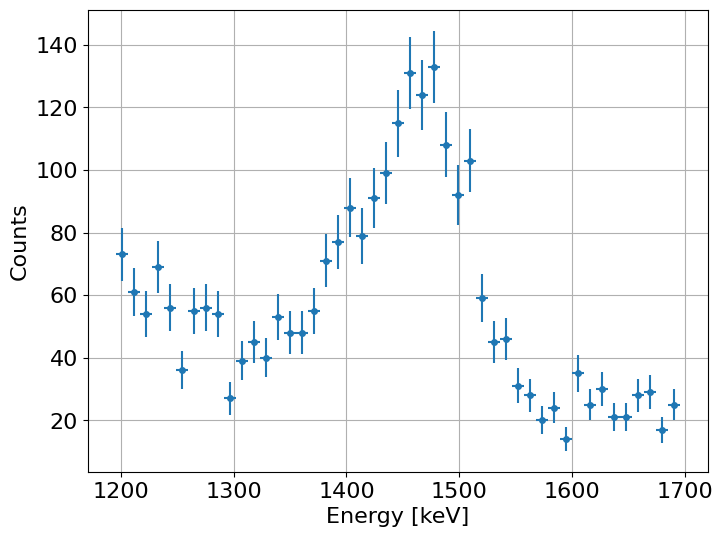

In [28]:
fig, ax = plt.subplots(figsize = (8, 6))

mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4
)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Counts")
ax.grid()
#ax.set_yscale("log")

In [29]:
def gaus (x, A, mu, sigma):
  return A * np.exp(-(x-mu)**2 / sigma**2)

def exponentially_decreasing (x, C, tau):
  return C * np.exp(-x / tau)

def gaus_exp (x, A, mu, sigma, C, tau):
  return gaus(x, A, mu, sigma) + exponentially_decreasing(x, C, tau)

In [30]:
lsq1 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus_exp
)

m1 = Minuit(lsq1, A = 100, mu = 1460, sigma = 50, C = 50, tau = 50)
m1.migrad()
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 79.59 (χ²/ndof = 1.9)      │              Nfcn = 520              │
│ EDM = 5.94e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │    94     │     5     │            │            │         │         │       │
│ 1 │ mu    │ 1.4596e3  │ 0.0023e3  │            │            │         │         │       │
│ 2 │ sigma │   61.9    │    3.1    │            │            │         │         │       │
│ 3 │ C     │  0.91e3   │  0.26e3   │            │            │         │         │       │
│ 4 │ tau   │    440    │    40     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │        A       mu    sigma        C      tau │
├───────┼──────────────────────────────────────────────┤
│     A │     22.3        2       -7      107      -19 │
│    mu │        2     5.39       -2       92      -12 │
│ sigma │       -7       -2     9.34      121      -25 │
│     C │      107       92      121 6.56e+04  -10.0e3 │
│   tau │      -19      -12      -25  -10.0e3 1.54e+03 │
└───────┴──────────────────────────────────────────────┘

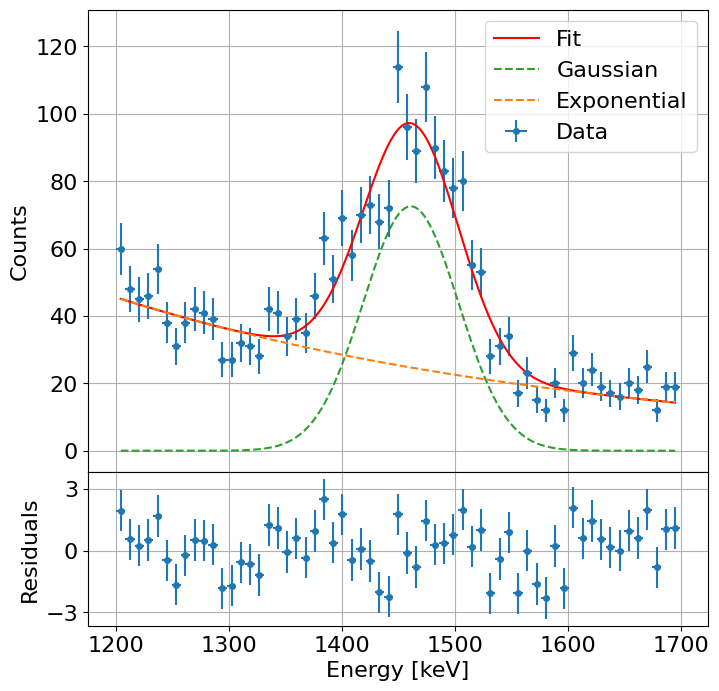

In [18]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus_exp(x, *m1.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m1.values[:3]), label = "Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m1.values[3:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus_exp(rebinned_energy[mask], *m1.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Il chi quadrato su gradi di libertà di questo fit è venuto di 1.8.

Possiamo provare ad utilizzare due gaussiane invece che una, in quanto è previsto che ad energie di circa 1400 ci sia un'altra linea spettrale della radioattività ambientale.

In [31]:
def gaus2_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + exponentially_decreasing(x, C, tau)

In [32]:
lsq2 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus2_exp
)
m2 = Minuit(lsq2, A1 = 100, mu1 = 1460, sigma1 = 50, A2 = 10, mu2 = 1400, sigma2 = 50, C = 50, tau = 460)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.14 (χ²/ndof = 1.9)      │             Nfcn = 1398              │
│ EDM = 0.00997 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    98     │     5     │            │            │         │         │       │
│ 1 │ mu1    │ 1.4572e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma1 │   67.0    │    3.4    │            │            │         │         │       │
│ 3 │ A2     │  0.28e3   │  0.17e3   │            │            │         │         │       │
│ 4 │ mu2    │  0.68e3   │  0.10e3   │            │            │         │         │       │
│ 5 │ sigma2 │    380    │    50     │            │            │         │         │       │
│ 6 │ C      │    28     │     9     │            │            │         │         │       │
│ 7 │ tau    │    6e3    │    6e3    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2        C      tau │
├────────┼─────────────────────────────────────────────────────────────────────────┤
│     A1 │     20.7        1       -5       70        9      -24       -3  1.346e3 │
│    mu1 │        1     6.01       -4     -119        7       36       -0     -550 │
│ sigma1 │       -5       -4     11.3      173       -1      -52       -3  1.210e3 │
│     A2 │       70     -119      173 3.05e+04 -0.013e6   -1.1e3      100 -0.017e6 │
│    mu2 │        9        7       -1 -0.013e6 1.05e+04   -3.2e3      -30  0.021e6 │
│ sigma2 │      -24       36      -52   -1.1e3   -3.2e3 2.53e+03      -60   20.6e3 │
│      C │       -3       -0       -3      100      -30      -60     82.2 -54.90e3 │
│    tau │  1.346e3     -550  1.210e3 -0.017e6  0.021e6   20.6e3 -54.90e3 3.88e+07 │
└────────┴─────────────────────────────────────────────────────────────────────────┘

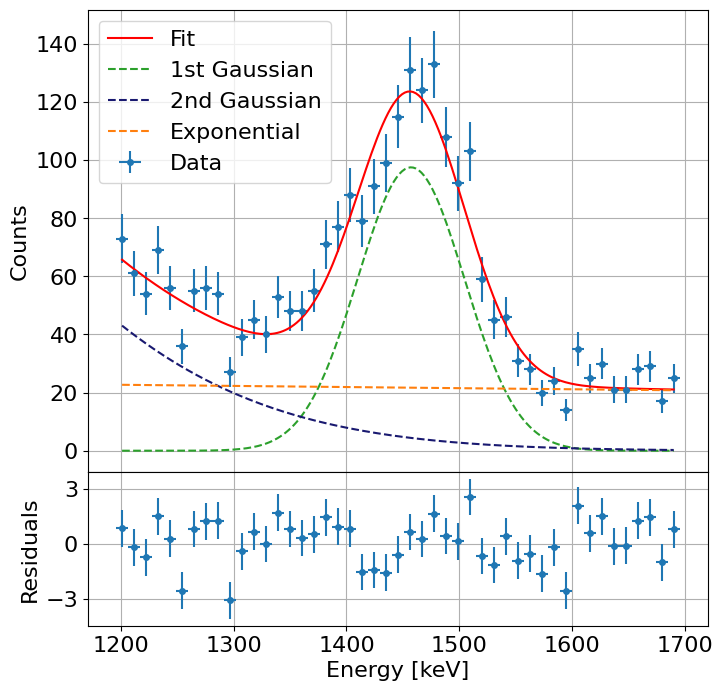

In [33]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus2_exp(x, *m2.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m2.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m2.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m2.values[6:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus2_exp(rebinned_energy[mask], *m2.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Non ha fatto ciò che volevamo!

Infatti, come media della seconda gaussiana ha dato 750, che è totalmente al di fuori del nostro range.

Esiste un modo per poter limitare l'intervallo di variabilità dei parametri nel fit.

In [34]:
lsq2 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus2_exp
)
m2 = Minuit(lsq2, A1 = 100, mu1 = 1460, sigma1 = 50, A2 = 10, mu2 = 1400, sigma2 = 50, C = 50, tau = 460)
m2.limits["mu2"] = (1330, 1440)
m2.limits["A2"] = (0, 1000)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.63 (χ²/ndof = 1.7)      │             Nfcn = 1360              │
│ EDM = 2.3e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    99     │     6     │            │            │         │         │       │
│ 1 │ mu1    │  1.469e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    50     │     4     │            │            │         │         │       │
│ 3 │ A2     │    32     │     8     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  1.394e3  │  0.007e3  │            │            │  1330   │  1440   │       │
│ 5 │ sigma2 │    30     │    11     │            │            │         │         │       │
│ 6 │ C      │  0.80e3   │  0.22e3   │            │            │         │         │       │
│ 7 │ tau    │    450    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2        C      tau │
├────────┼─────────────────────────────────────────────────────────────────────────┤
│     A1 │     30.6       -1       -6        6       -5      -11       67      -15 │
│    mu1 │       -1     16.3      -13       15       22       32      -60        9 │
│ sigma1 │       -6      -13       19      -19      -21      -27      207      -40 │
│     A2 │        6       15      -19     59.3       20        0     -140       20 │
│    mu2 │       -5       22      -21       20       50       50     -140       30 │
│ sigma2 │      -11       32      -27        0       50      126  -0.33e3   0.05e3 │
│      C │       67      -60      207     -140     -140  -0.33e3    5e+04   -9.3e3 │
│    tau │      -15        9      -40       20       30   0.05e3   -9.3e3 1.74e+03 │
└────────┴─────────────────────────────────────────────────────────────────────────┘

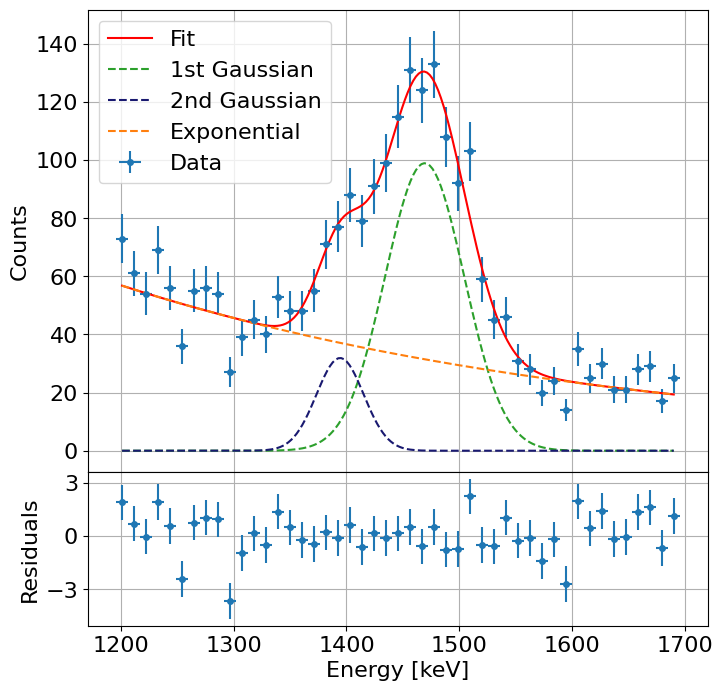

In [35]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus2_exp(x, *m2.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m2.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m2.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m2.values[6:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus2_exp(rebinned_energy[mask], *m2.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Ora il fit è andato a buon fine!

Il chi quadrato su gradi di libertà è anche migliorato da 1.8 a 1.5.

Sono stati due fit a 5 gradi di libertà e 8 gradi di libertà, perciò il chi quadrato minimo si distribuisce secondo una distribuzione di chi quadrato a 3 gradi di libertà

In [36]:
from scipy.stats import chi2

In [37]:
m2.fval, m2.ndof,m2.fval/m2.ndof

(64.62861422590903, 39.0, 1.657143954510488)

In [38]:
m1.fval, m1.ndof, m1.fval/m1.ndof

(79.59325427552886, 42.0, 1.8950774827506873)

14.964640049619831 3.0
0.0018471171574055978


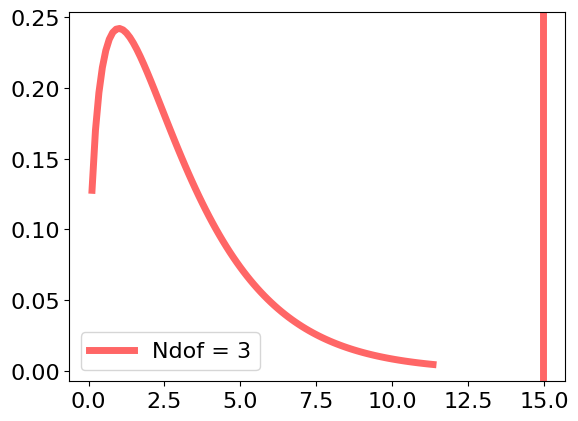

In [39]:
fval = - m2.fval + m1.fval
df = - m2.ndof + m1.ndof
print (fval, df)

fig, ax = plt.subplots()

x = np.linspace(chi2.ppf(0.01, df),
               chi2.ppf(0.99, df), 100)
ax.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='Ndof = %d' % df);
ax.axvline(fval, color = "red", lw=5, alpha=0.6)
ax.legend();
print (1-chi2.cdf(fval, df))

Ne deduciamo che il miglioramento del fit con l'utilizzo di 2 gaussiane invece che una è significativo con livello di confidenza maggiore del 95%!

Dunque, possiamo dire che siamo stati in grado di osservare una riga spettrale a $1404 \pm 19$ keV. Infatti, ce ne sta una del bismuto-214 a 1408 keV, con branching ratio di 2.4.

Tuttavia, c'è anche da dire che cene sta un'altra, sempre del bismuto-214, ad energia di $1509$ keV, con un branching ratio di 2.1!

Dunque, conviene provare un fit con 3 gaussiane e vedere se il miglioramento nel fit è significativo.

In [40]:
def gaus3_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + gaus(x, A3, mu3, sigma3) + exponentially_decreasing(x, C, tau)

In [51]:
lsq3 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus3_exp
)
m3 = Minuit(lsq3, A1 = 100, mu1 = 1460, sigma1 = 20, A2 = 34, mu2 = 1403, sigma2 = 19, A3 = 40, mu3 = 1510 , sigma3 = 20 , C = 50, tau = 460)
m3.limits["sigma1"] = (0, 40)
m3.limits["sigma2"] = (0, 27)
m3.limits["sigma3"] = (0, 27)
m3.limits["mu2"] = (1440, 1480)
m3.limits["mu2"] = (1370, 1430)
m3.limits["mu3"] = (1480, 1540)
m3.limits["A2"] = (0, 1000)
m3.limits["A3"] = (0, 1000)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.82 (χ²/ndof = 1.8)      │             Nfcn = 1631              │
│ EDM = 0.000152 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    97     │     8     │            │            │         │         │       │
│ 1 │ mu1    │  1.462e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    40     │    28     │            │            │    0    │   40    │       │
│ 3 │ A2     │    38     │     6     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  1.396e3  │  0.004e3  │            │            │  1370   │  1430   │       │
│ 5 │ sigma2 │    27     │    17     │            │            │    0    │   27    │       │
│ 6 │ A3     │    31     │    12     │            │            │    0    │  1000   │       │
│ 7 │ mu3    │  1.509e3  │  0.007e3  │            │            │  1480   │  1540   │       │
│ 8 │ sigma3 │    27     │    18     │            │            │    0    │   27    │       │
│ 9 │ C      │  0.76e3   │  0.21e3   │            │            │         │         │       │
│ 10│ tau    │    460    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3        C      tau │
├────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     A1 │     59.2       18     0.00       10        3  0.03e-3      -60       30  -1.5e-3      200      -50 │
│    mu1 │       18     18.7     0.07       15       10  0.20e-3      -42       19  -0.8e-3       74      -15 │
│ sigma1 │     0.00     0.07    0.122    -0.11    -0.05       -0    -0.37     0.08       -0     0.26    -0.07 │
│     A2 │       10       15    -0.11     40.4       11 -0.09e-3      -30       10  -0.4e-3       40      -10 │
│    mu2 │        3       10    -0.05       11     18.7  0.15e-3      -20        8  -0.3e-3       65      -11 │
│ sigma2 │  0.03e-3  0.20e-3       -0 -0.09e-3  0.15e-3 0.000105 -0.36e-3  0.16e-3       -0 -0.25e-3 -0.03e-3 │
│     A3 │      -60      -42    -0.37      -30      -20 -0.36e-3      132      -60   1.0e-3  -0.04e3        0 │
│    mu3 │       30       19     0.08       10        8  0.16e-3      -60     43.9  -1.2e-3      200      -40 │
│ sigma3 │  -1.5e-3  -0.8e-3       -0  -0.4e-3  -0.3e-3       -0   1.0e-3  -1.2e-3 0.000785   8.1e-3  -1.9e-3 │
│      C │      200       74     0.26       40       65 -0.25e-3  -0.04e3      200   8.1e-3 4.36e+04   -8.7e3 │
│    tau │      -50      -15    -0.07      -10      -11 -0.03e-3        0      -40  -1.9e-3   -8.7e3 1.78e+03 │
└────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

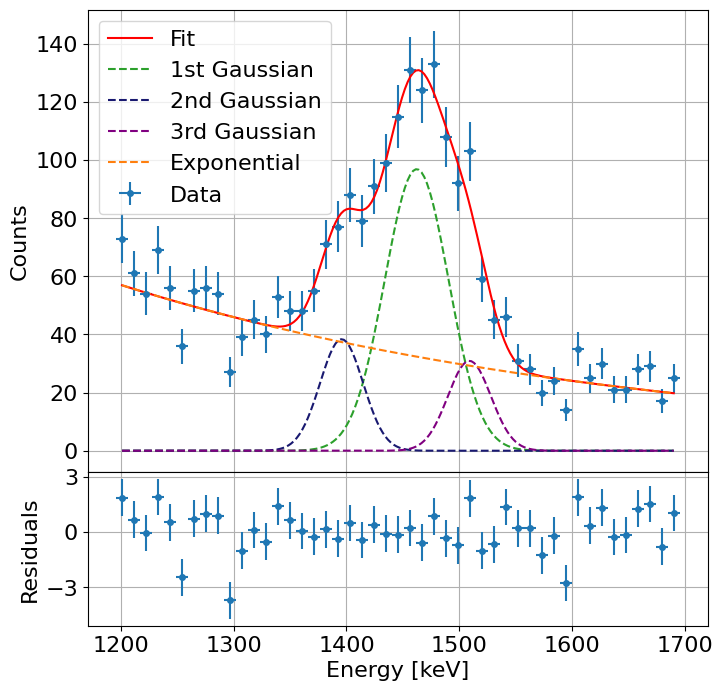

In [52]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus3_exp(x, *m3.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m3.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[6:9]), label = "3rd Gaussian", color = "purple", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m3.values[9:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus3_exp(rebinned_energy[mask], *m3.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

In [53]:
np.trapz(gaus(x, *m3.values[:3]), x), np.trapz(gaus(x, *m3.values[3:6]), x), np.trapz(gaus(x, *m3.values[6:9]), x)

(6869.742042027321, 1836.8294587587413, 1480.3814589344588)

In [55]:
np.trapz(gaus(x, *m3.values[3:6]), x) / np.trapz(gaus(x, *m3.values[6:9]), x), 2.4 / 2.1

(1.2407811835747016, 1.1428571428571428)

Questo fit invece non mi soddisfa particolarmente! Il chi quadro normalizzato è lo stesso del fit con 2 gaussiane, inoltre i picco a 1400 keV dovrebbe essere più intenso di quello a 1500 keV...

Vediamo se statisticamente è meglio o meno.

0.8132513462099311 3.0
0.8462949313379585


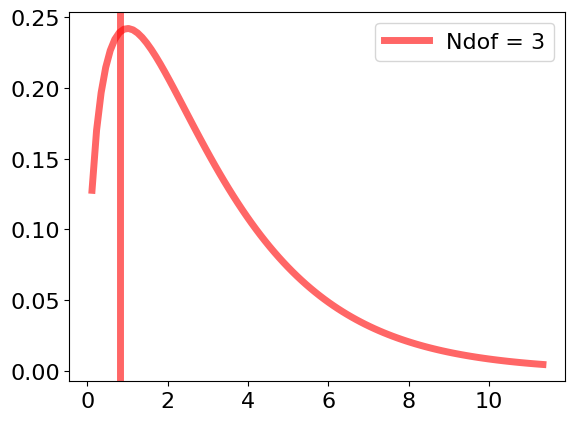

In [56]:
fval = - m3.fval + m2.fval
df = - m3.ndof + m2.ndof
print (fval, df)

fig, ax = plt.subplots()

x = np.linspace(chi2.ppf(0.01, df),
               chi2.ppf(0.99, df), 100)
ax.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='Ndof = %d' % df);
ax.axvline(fval, color = "red", lw=5, alpha=0.6)
ax.legend();
print (1-chi2.cdf(fval, df))

In [50]:
from scipy.special import erfinv

def pval_to_sigma (pval):
  return erfinv(pval) * np.sqrt(2)

pval_to_sigma(chi2.cdf(fval, df))

0.24760084720525954

Non lo è, perchè il p-valore è elevato, corrispondente a bassi valori di significatività!

In [60]:
def gaus4_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, A4, mu4, sigma4, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + gaus(x, A3, mu3, sigma3) + gaus(x, A4, mu4, sigma4) + exponentially_decreasing(x, C, tau)

lsq4 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus4_exp
)
m4 = Minuit(lsq4, A1 = 100, mu1 = 1460, sigma1 = 20, A2 = 34, mu2 = 1403, sigma2 = 19, A3 = 40, mu3 = 1510 , sigma3 = 20 , A4 = 100, mu4 = 1375, sigma4 = 20, C = 30, tau = 460)
m = m4
m.limits["sigma1"] = (10, 40)
m.limits["sigma2"] = (10, 27)
m.limits["sigma3"] = (10, 27)
m.limits["sigma4"] = (10, 27)
m.limits["mu1"] = (1440, 1480)
m.limits["mu2"] = (1370, 1430)
m.limits["mu3"] = (1480, 1540)
m.limits["mu4"] = (1360, 1400)
m.limits["A2"] = (0, 1000)
m.limits["A3"] = (0, 1000)
m.limits["A4"] = (0, 1000)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.81 (χ²/ndof = 1.9)      │             Nfcn = 2901              │
│ EDM = 4.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    97     │     8     │            │            │         │         │       │
│ 1 │ mu1    │  1.462e3  │  0.005e3  │            │            │  1440   │  1480   │       │
│ 2 │ sigma1 │    40     │    22     │            │            │   10    │   40    │       │
│ 3 │ A2     │    38     │     7     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  1.398e3  │  0.005e3  │            │            │  1370   │  1430   │       │
│ 5 │ sigma2 │    24     │    10     │            │            │   10    │   27    │       │
│ 6 │ A3     │    32     │    13     │            │            │    0    │  1000   │       │
│ 7 │ mu3    │  1.509e3  │  0.007e3  │            │            │  1480   │  1540   │       │
│ 8 │ sigma3 │    27     │    12     │            │            │   10    │   27    │       │
│ 9 │ A4     │     7     │     7     │            │            │    0    │  1000   │       │
│ 10│ mu4    │  1.36e3   │  0.04e3   │            │            │  1360   │  1400   │       │
│ 11│ sigma4 │    26     │    15     │            │            │   10    │   27    │       │
│ 12│ C      │  0.74e3   │  0.21e3   │            │            │         │         │       │
│ 13│ tau    │    470    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3       A4      mu4   sigma4        C      tau │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     A1 │     59.1       19  0.01e-3       10        4        0      -60       30 -0.27e-3        0    0.000        0      190      -50 │
│    mu1 │       19     28.4 -0.12e-3        9       15       23      -60       27 -0.18e-3       -8    0.000        6       94      -21 │
│ sigma1 │  0.01e-3 -0.12e-3 6.84e-05  0.31e-3  0.18e-3  0.20e-3  0.97e-3 -0.18e-3        0 -0.06e-3       -0  0.03e-3 -0.71e-3  0.17e-3 │
│     A2 │       10        9  0.31e-3     51.1        4      -10      -20       10 -0.05e-3        0    0.002      -20       60      -20 │
│    mu2 │        4       15  0.18e-3        4     22.3       13      -29       13 -0.07e-3        5   -0.001        7       21       -7 │
│ sigma2 │        0       23  0.20e-3      -10       13     50.7      -40       20 -0.10e-3      -30    0.001       10       90      -20 │
│     A3 │      -60      -60  0.97e-3      -20      -29      -40      163      -70  0.25e-3       10   -0.000  -0.01e3  -0.07e3   0.01e3 │
│    mu3 │       30     

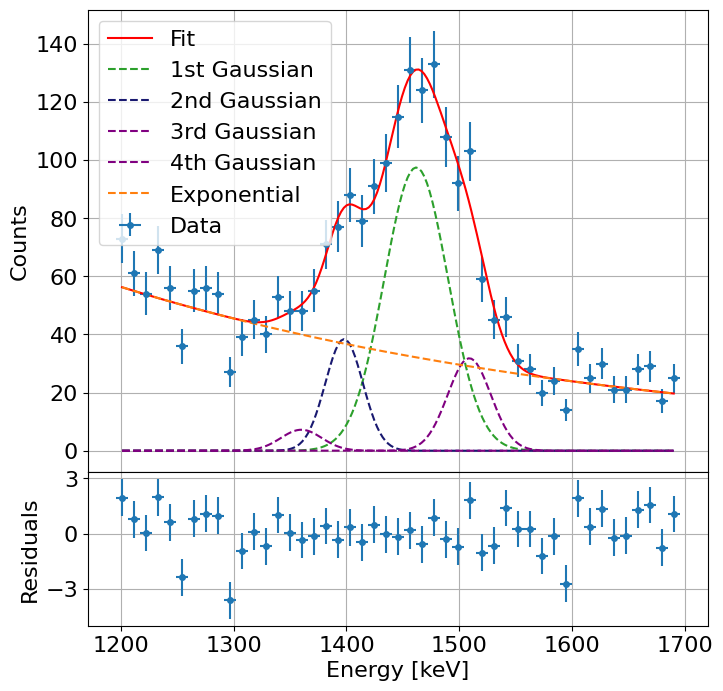

In [61]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus4_exp(x, *m3.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m3.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[6:9]), label = "3rd Gaussian", color = "purple", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[9:12]), label = "4th Gaussian", color = "purple", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m4.values[12:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus4_exp(rebinned_energy[mask], *m4.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

In [76]:
def gaus4_exp (x, A1, sigma1, A, sigma, C, tau):
  return gaus(x, A1, 1460, sigma1) + gaus(x, A, 1378, sigma) + gaus(x, A * 2.4/(3.9*1.1), 1408, sigma) + gaus(x, A*2.1/(3.9*1.2), 1509, sigma) + exponentially_decreasing(x, C, tau)

lsq4 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus4_exp
)
m4 = Minuit(lsq4, A1 = 100, sigma1 = 30, A = 100, sigma = 10, C = 30, tau = 460)
m = m4
#m.limits["sigma1"] = (30, 50)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.7 (χ²/ndof = 1.7)       │              Nfcn = 716              │
│ EDM = 1.1e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    94     │     5     │            │            │         │         │       │
│ 1 │ sigma1 │    55     │     4     │            │            │         │         │       │
│ 2 │ A      │    17     │     9     │            │            │         │         │       │
│ 3 │ sigma  │    19     │    15     │            │            │         │         │       │
│ 4 │ C      │  0.77e3   │  0.22e3   │            │            │         │         │       │
│ 5 │ tau    │    460    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1   sigma1        A    sigma        C      tau │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     26.1       -7        8      -10       49      -12 │
│ sigma1 │       -7     17.5       -5      -23      274      -57 │
│      A │        8       -5     85.4     -100      -40       10 │
│  sigma │      -10      -23     -100      212  -0.49e3   0.08e3 │
│      C │       49      274      -40  -0.49e3  4.8e+04   -9.4e3 │
│    tau │      -12      -57       10   0.08e3   -9.4e3 1.88e+03 │
└────────┴───────────────────────────────────────────────────────┘

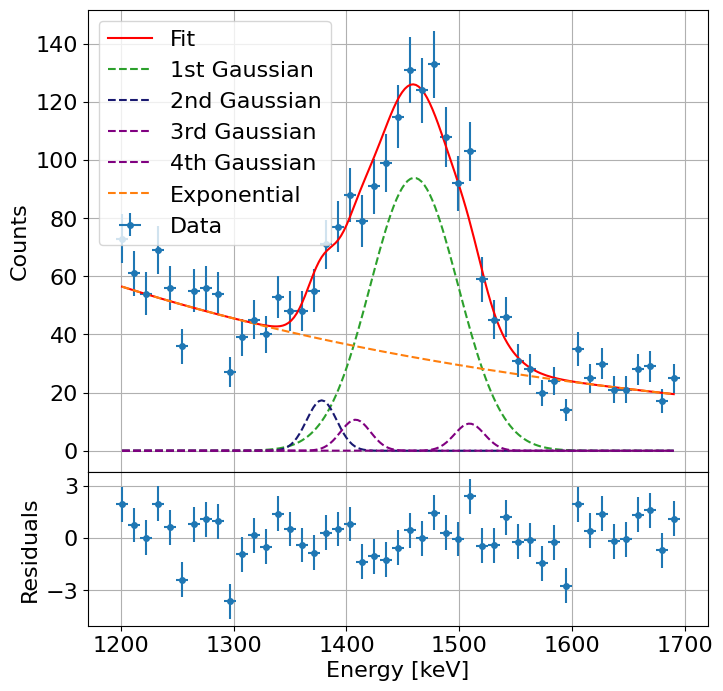

In [79]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus4_exp(x, *m4.values), label = "Fit", color = "red")
A1, sigma1, A, sigma, C, tau = m4.values
ax.plot(x, gaus(x, A1, 1460, sigma1), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, A, 1378, sigma), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, gaus(x, A * 2.4/(3.9), 1408, sigma), label = "3rd Gaussian", color = "purple", ls = "dashed")
ax.plot(x, gaus(x, A*2.1/(3.9), 1509, sigma), label = "4th Gaussian", color = "purple", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m4.values[-2:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus4_exp(rebinned_energy[mask], *m4.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

In [72]:
sigma, sigma1

(18.795524923264022, 54.941073997188425)

## Step 4b - Analisi dei picchi ad energie da 200 a 400 keV

Provate a fare voi!

Dovete solo prendere pezzi di codice presenti sopra e riprodurre il fit ed il plot!

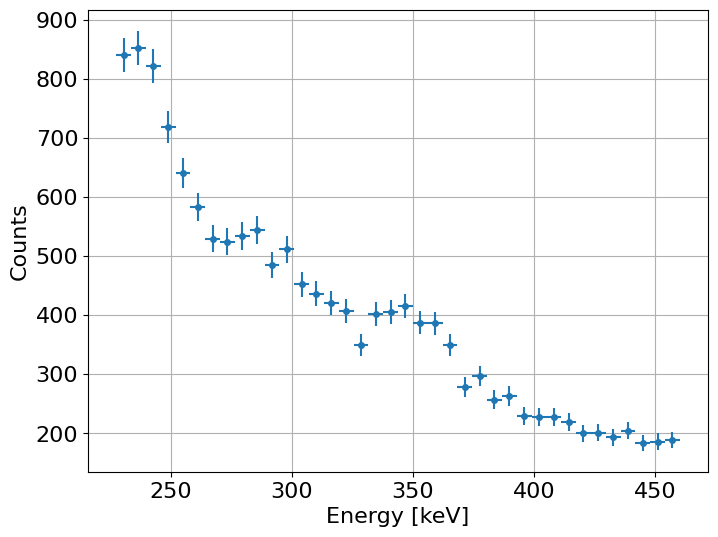

In [150]:
#####################################
# Insert your code here

# A che serve questo?
rebinned_adc, rebinned_counts = rebin_histogram(adc, counts, 15)
rebinned_energy = (rebinned_adc - p0) / p1

# Definition of the mask
mask = (rebinned_energy > 226) * (rebinned_energy < 460)

# Plot
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4
)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Counts")
ax.grid()

#####################################

In [151]:
#####################################
# Insert your code here

# Code
def gaus3_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + gaus(x, A3, mu3, sigma3) + exponentially_decreasing(x, C, tau)

# Fit
lsq3 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus3_exp
)
m3 = Minuit(lsq3, A1 = 100, mu1 = 230, sigma1 = 20, A2 = 34, mu2 = 270, sigma2 = 19, A3 = 40, mu3 = 350, sigma3 = 20 , C = 50, tau = 460)
m3.limits["sigma1"] = (0, 30)
m3.limits["sigma2"] = (0, 30)
m3.limits["sigma3"] = (0, 30)
m3.limits["A2"] = (0, 1000)
m3.limits["A3"] = (0, 1000)
m3.migrad()
m3.hesse()

#####################################

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.88 (χ²/ndof = 0.7)      │             Nfcn = 2005              │
│ EDM = 0.473 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    440    │    70     │            │            │         │         │       │
│ 1 │ mu1    │   235.2   │    2.2    │            │            │         │         │       │
│ 2 │ sigma1 │    23     │     4     │            │            │    0    │   30    │       │
│ 3 │ A2     │    190    │    40     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │   289.1   │    3.2    │            │            │         │         │       │
│ 5 │ sigma2 │    30     │     5     │            │            │    0    │   30    │       │
│ 6 │ A3     │    131    │    19     │            │            │    0    │  1000   │       │
│ 7 │ mu3    │   349.7   │    2.1    │            │            │         │         │       │
│ 8 │ sigma3 │    24     │     5     │            │            │    0    │   30    │       │
│ 9 │ C      │   0.9e3   │   0.4e3   │            │            │         │         │       │
│ 10│ tau    │    280    │    70     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3        C      tau │
├────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     A1 │ 4.95e+03      -52      122    2.9e3      -38       -5    1.0e3      -52      249    -24e3      5e3 │
│    mu1 │      -52     4.69       -6      -20       -1        0      -10        0       -2      243      -47 │
│ sigma1 │      122       -6     14.4       55        6       -2       30       -0        4     -666      130 │
│     A2 │    2.9e3      -20       55 1.89e+03      -39       -1    0.6e3      -33      154  -14.8e3    2.9e3 │
│    mu2 │      -38       -1        6      -39     10.2       -1       -5        3       -7      187      -35 │
│ sigma2 │       -5        0       -2       -1       -1      3.9       -2        1       -1       -1        0 │
│     A3 │    1.0e3      -10       30    0.6e3       -5       -2      369      -10       39   -5.4e3    1.0e3 │
│    mu3 │      -52        0       -0      -33        3        1      -10     4.56       -5      265      -52 │
│ sigma3 │      249       -2        4      154       -7       -1       39       -5       24 -1.262e3      240 │
│      C │    -24e3      243     -666  -14.8e3      187       -1   -5.4e3      265 -1.262e3 1.27e+05    -25e3 │
│    tau │      5e3      -47      130    2.9e3      -35        0    1.0e3      -52      240    -25e3 4.86e+03 │
└────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

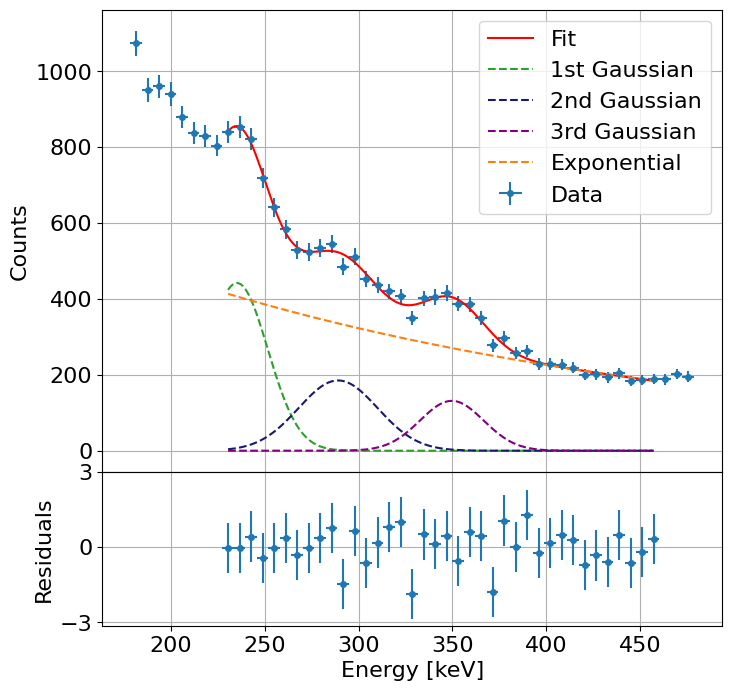

In [152]:
#####################################
# Insert your code here

fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

mask1 = (rebinned_energy > 180) * (rebinned_energy < 480)

ax = axs[0]
ax.errorbar(
    rebinned_energy[mask1],
    rebinned_counts[mask1],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask1]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus3_exp(x, *m3.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m3.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[6:9]), label = "3rd Gaussian", color = "purple", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m3.values[9:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus3_exp(rebinned_energy[mask], *m3.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

#####################################

In [134]:
m3.values["mu1"], m3.values["mu2"], m3.values["mu3"]

(236.1320491676621, 289.0544714432843, 348.7037696929115)

In [135]:
m3.values["sigma1"], m3.values["sigma2"], m3.values["sigma3"]

(22.64096523922124, 27.94159593449182, 25.31483037560765)

In [136]:
m3.values["sigma1"]/m3.values["mu1"], m3.values["sigma2"]/ m3.values["mu2"], m3.values["sigma3"]/m3.values["mu3"]

(0.09588264413504223, 0.09666550320074974, 0.07259695069514543)